# 01 Server Rackmount Forecast

Quick validation notebook for the `data/processed/synosales_cleaned.parquet` output. Once the structure is confirmed, lift the aggregation logic into a production module under `src/` as part of the export-to-module plan.

## Notebook Purpose & Flow
This notebook validates the SVR-RM forecasting flow described in `documents/implementation/summary.md` and `documents/strategy/PRD.md`.
It loads the cleaned sales snapshot, runs exploratory diagnostics, and compares SARIMAX vs AutoARIMA baselines so the logic can later be promoted into production modules.


### 1. Environment Setup
Import scientific Python libraries plus statsmodels components for SARIMAX fits and seaborn/matplotlib for visuals.


In [229]:
import numpy as np
import os
import sys
from pathlib import Path
import pandas as pd
import warnings
import sklearn
import itertools
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

In [230]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import seaborn as sns



#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [231]:
os.getcwd()

'/Users/tonychu/Git Repository/syno_prediction/notebook'

### 2. Load Processed Snapshot
Read `data/processed/synosales_cleaned.parquet`, split NAS vs C2 cohorts, and keep the SVR-RM scope required by the forecasting PRD.


In [232]:
repo = Path("/Users/tonychu/Git Repository/syno_prediction")
df = pd.read_parquet(repo / "data/processed/synosales_cleaned.parquet")

suite_NAS = df[df["source_sheet"].isin(["2023", "2024"])]
suite_C2 = df[df["source_sheet"].isin(["2023-C2", "2024-C2"])]

### 3. Filter & Sanity-Check SVR-RM Records
Select the relevant columns, enforce dtypes, and filter to `sub_cat` entries starting with `SVR-RM` so downstream aggregates stay on the right product tier.


In [233]:
suite_NAS_subset = suite_NAS[["PI", "Customer", "ItemCode", "Product", "Quantity", "usd_adjusted_price", "usd_adjusted_total", "InvDate", "Country", "Type", "sub_cat", "Year", "Region", "source_sheet"]].copy()
suite_C2_subset = suite_C2[["PI", "Customer", "ItemCode", "Product", "Quantity", "usd_adjusted_price", "usd_adjusted_total", "InvDate", "Country", "Type", "sub_cat", "Year", "Region", "source_sheet"]].copy()

In [234]:
suite_NAS_subset["InvDate"] = pd.to_datetime(suite_NAS_subset["InvDate"])
suite_NAS_subset["usd_adjusted_total"] = suite_NAS_subset["usd_adjusted_total"].astype(float)

In [235]:
suite_NAS_clean = suite_NAS_subset[suite_NAS_subset["sub_cat"].fillna("").str.startswith("SVR-RM")].copy()

In [236]:
suite_NAS_clean.head(20)

,PI,Customer,ItemCode,Product,Quantity,usd_adjusted_price,usd_adjusted_total,InvDate,Country,Type,sub_cat,Year,Region,source_sheet
30911,268437.0,HORNINGTON,90-R368S0231,RS3618xs,2,2680.000,5306.400,2023-01-03,Hong Kong,SERVER,SVR-RM-GP-T2,2023,HQ,2023
30920,268753.0,HORNINGTON,90-R1221P231,RS1221+,4,979.000,3876.840,2023-01-03,Hong Kong,SERVER,SVR-RM-GP-T1,2023,HQ,2023
30921,268753.0,HORNINGTON,90-R1221R231,RS1221RP+,2,1335.000,2643.300,2023-01-03,Hong Kong,SERVER,SVR-RM-GP-T1,2023,HQ,2023
30922,268753.0,HORNINGTON,90-R422P0231,RS422+,1,679.000,672.210,2023-01-03,Hong Kong,SERVER,SVR-RM-GP-T1,2023,HQ,2023
30923,268753.0,HORNINGTON,90-RXC7R0231,RX1217RP,1,1600.000,1584.000,2023-01-03,Hong Kong,SERVER,SVR-RM-GX-T3,2023,HQ,2023
30927,261629.0,NAS2U,90-R368S0231,RS3618xs,12,2006.000,24072.000,2023-01-03,Malaysia,SERVER,SVR-RM-GP-T2,2023,HQ,2023
30931,267686.0,Mushor,90-R822P0231,RS822+,2,834.000,1668.000,2023-01-03,Saudi Arabia,SERVER,SVR-RM-GP-T1,2023,HQ,2023
30933,267687.0,Mushor,90-R36LX1231,RS3621xs+,1,3842.000,3842.000,2023-01-03,Saudi Arabia,SERVER,SVR-RM-GP-T3,2023,HQ,2023
30935,268279.0,Mushor,90-R822R0231,RS822RP+,1,1053.000,1053.000,2023-01-03,Saudi Arabia,SERVER,SVR-RM-GP-T1,2023,HQ,2023
30936,268279.0,Mushor,90-R169X0231,RS1619xs+,1,1542.000,1542.000,2023-01-03,Saudi Arabia,SERVER,SVR-RM-GP-T3,2023,HQ,2023


### 4. Build Monthly Aggregations & Price Tables
Aggregate SVR-RM sales by product/month and compute unit pricing so we can translate volume forecasts into revenue.


In [237]:
monthly_product_metrics = (
    suite_NAS_clean.assign(
        InvDate=pd.to_datetime(suite_NAS_clean["InvDate"], errors="coerce")
    )
    .dropna(subset=["InvDate"])
    .groupby(["Product", pd.Grouper(key="InvDate", freq="M")])
    .agg(
        Quantity=("Quantity", "sum"),
        usd_adjusted_total=("usd_adjusted_total", "sum"),
    )
    .reset_index()
    .rename(columns={"usd_adjusted_total": "actual_revenue"})
)



/var/folders/dt/7vnpb4hn01d19x7dfz27zs5h0000gn/T/ipykernel_58710/57640934.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(["Product", pd.Grouper(key="InvDate", freq="M")])


In [238]:
monthly_product_metrics

,Product,InvDate,Quantity,actual_revenue
0,FS2500,2023-01-31,63,160555.6977
1,FS2500,2023-02-28,71,177931.4385
2,FS2500,2023-03-31,85,219618.3254
3,FS2500,2023-04-30,82,196717.8562
4,FS2500,2023-05-31,110,263889.4655
...,...,...,...,...
828,UC3400,2024-08-31,16,94562.5555
829,UC3400,2024-09-30,4,21673.5960
830,UC3400,2024-10-31,13,81630.6860
831,UC3400,2024-11-30,24,183086.7365


In [239]:
product_prices = (
    suite_NAS_clean.groupby("Product")["usd_adjusted_price"]
    .mean()
    .reset_index()
    .rename(columns={"usd_adjusted_price": "avg_price"})
)

In [240]:
product_prices.head(20)


,Product,avg_price
0,FS2500,2650.925721
1,FS3017,NaN
2,FS3410,5552.205238
3,FS3600,7246.367742
4,FS6400,10060.501224
5,FX2421,2587.970899
6,HD6500,13664.376225
7,RS1221+,971.835361
8,RS1221RP+,1318.645679
9,RS1619xs+,1655.412035


### 5. Data Exploratory
Trend the monthly totals, inspect stationarity (log + differencing), and build intuition before fitting models.


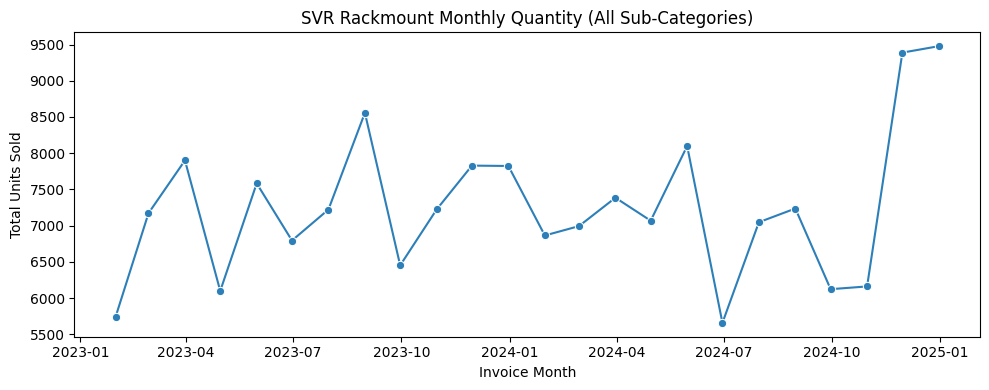

In [241]:
df_monthly_totals = (
    suite_NAS_clean
    .groupby(pd.Grouper(key="InvDate", freq="ME"))["Quantity"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_monthly_totals, x="InvDate", y="Quantity", marker="o", color="#2c7fb8")
plt.title("SVR Rackmount Monthly Quantity (All Sub-Categories)")
plt.xlabel("Invoice Month")
plt.ylabel("Total Units Sold")
plt.tight_layout()
plt.show()

**Insights – Monthly Totals & Stationarity**
- Monthly SVR-RM volume shows alternating YoY surges (Jan/Apr/Nov/Dec) and dips (Jun–Oct), which ties directly to the seasonality checklist in `documents/strategy/data_analytics_playbook.md` and flags which months drive the PRD’s revenue objective.
- Applying log + first + seasonal differencing produces a stationary series where only lag-1 autocorrelation remains, supporting the shared `(1,1,1)x(1,1,1,12)` orders later in the notebook.
- With only 24 months of history we still lack the 2–3 year product-cycle repetitions described in `documents/strategy/PRD.md`, so deeper lifecycle seasonality remains an assumption to revisit once additional snapshots land.


In [242]:
# Ensure chronological order
df_monthly_totals = df_monthly_totals.sort_values("InvDate")

# Log + first difference + seasonal difference (lag 12)
log_units = np.log(df_monthly_totals["Quantity"].clip(lower=1))
diff1 = log_units.diff()
diff_seasonal = diff1.diff(12)

acf_input = diff_seasonal.dropna()

In [243]:
from statsmodels.tsa.stattools import adfuller

adf_stat, p_value, *_ = adfuller(acf_input)
print(f"ADF statistic: {adf_stat:.2f}, p-value: {p_value:.4f}")

ADF statistic: -4.44, p-value: 0.0002


An ADF statistic of ‑4.44 with p≈0.0002 confirms the log → first → seasonal differenced series is stationary at the 1% level. That backs up your choice of (1,1,1)x(1,1,1,12) in the SARIMAX baseline since both the visual ACF/PACF and the formal test say no unit root remains after those transformations.

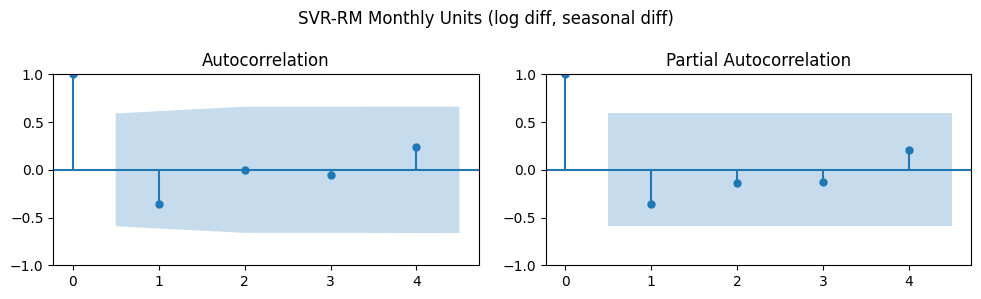

In [244]:
max_lags = min(4, len(acf_input) // 2 - 1)  # yields 4 with your sample size

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(acf_input, ax=axes[0], lags=max_lags)
plot_pacf(acf_input, ax=axes[1], lags=max_lags, method="ywm")
fig.suptitle("SVR-RM Monthly Units (log diff, seasonal diff)")
plt.tight_layout()
plt.show()

### 5a. Sub-Category Trend Exploration
Group by `sub_cat` and month to show how each SVR tier contributes to demand swings, aligning with tier KPIs in the implementation plan.


In [245]:
df_monthly_subcat_metrics = (
    suite_NAS_clean
    .groupby(["sub_cat",pd.Grouper(key="InvDate", freq="ME")])
    .agg(Quantity=("Quantity", "sum"), usd_adjusted_total=("usd_adjusted_total", "sum"))
    .reset_index()
    .rename(columns={"usd_adjusted_total": "actual_revenue"})
)


In [246]:
df_monthly_subcat_metrics

,sub_cat,InvDate,Quantity,actual_revenue
0,SVR-RM-FS-T1,2023-01-31,63,160555.6977
1,SVR-RM-FS-T1,2023-02-28,71,177931.4385
2,SVR-RM-FS-T1,2023-03-31,85,219618.3254
3,SVR-RM-FS-T1,2023-04-30,82,196717.8562
4,SVR-RM-FS-T1,2023-05-31,110,263889.4655
...,...,...,...,...
306,SVR-RM-GX-T5,2024-07-31,9,49485.3820
307,SVR-RM-GX-T5,2024-09-30,8,45155.7600
308,SVR-RM-GX-T5,2024-10-31,11,60538.9075
309,SVR-RM-GX-T5,2024-11-30,8,46307.0000


### 6. SARIMAX Baseline per Product
Fit a fixed `(1,1,1)x(1,1,1,12)` SARIMAX for each SKU (train data through 2024-09) to act as the control forecast referenced in phase 04.


In [247]:
MONTHLY_FREQ = "M"
SEASONAL_PERIOD = 12
MIN_SEASONAL_HISTORY = SEASONAL_PERIOD * 2

# Containers for results
forecasts = []
errors = []


def _prepare_series(values: pd.Series, index: pd.Series) -> pd.Series:
    period_index = pd.PeriodIndex(index, freq=MONTHLY_FREQ)
    series = pd.Series(values, index=period_index, name="quantity").sort_index()
    series = series.astype(float).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return series.asfreq(MONTHLY_FREQ, fill_value=0.0)


for product, df_prod in monthly_product_metrics.groupby("Product"):
    df_prod = df_prod.copy()
    df_prod["InvDate"] = pd.to_datetime(df_prod["InvDate"], errors="coerce")
    df_prod = df_prod.dropna(subset=["InvDate"]).sort_values("InvDate")

    train_mask = df_prod["InvDate"] <= "2024-09-30"
    train = df_prod.loc[train_mask]
    test = df_prod.loc[~train_mask]

    if len(train) < 12 or test.empty:
        continue  # skip if less than one year of data

    quantity_series = _prepare_series(train["Quantity"].values, train["InvDate"])
    if quantity_series.empty:
        continue

    seasonal_order = (
        (0, 0, 0, SEASONAL_PERIOD)
        if len(quantity_series) < MIN_SEASONAL_HISTORY
        else (1, 1, 1, SEASONAL_PERIOD)
    )

    train_log = np.log(quantity_series.clip(lower=1.0))
    train_log.name = "log_quantity"

    # Fit SARIMAX
    try:
        model = SARIMAX(
            train_log,
            order=(1, 1, 1),
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        fit = model.fit(disp=False)

        steps = len(test)
        forecast = fit.get_forecast(steps=steps)
        pred_mean = np.exp(forecast.predicted_mean)
        conf_int = forecast.conf_int(alpha=0.05)
        conf_int_exp = np.exp(conf_int)
        lower = conf_int_exp.iloc[:, 0].values
        upper = conf_int_exp.iloc[:, 1].values

        # Compute MAPE for this product
        mape = np.mean(
            np.abs(test["Quantity"].values - pred_mean.values)
            / np.maximum(test["Quantity"].values, 1)
        ) * 100

        forecast_months = pred_mean.index.to_timestamp(how="end")

        # Save results
        temp = pd.DataFrame({
            "Product": product,
            "forecast_month": forecast_months,
            "forecast_volume": pred_mean.values,
            "forecast_lower": lower,
            "forecast_upper": upper,
            "actual_revenue": test["actual_revenue"].values,
            "actual_volume": test["Quantity"].values,
        })
        forecasts.append(temp)
        errors.append({"Product": product, "MAPE": mape})

    except Exception as e:
        print(f"Skipping {product}: {e}")



In [248]:
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:           log_quantity   No. Observations:                   17
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -13.779
Date:                Sat, 15 Nov 2025   AIC                             33.557
Time:                        21:44:54   BIC                             35.474
Sample:                    05-31-2023   HQIC                            33.380
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2501      0.905     -0.276      0.782      -2.023       1.523
ma.L1         -0.2152      0.893     -0.241      0.810      -1.965       1.535
sigma2         0.4191      0.225      1.865      0.0

**Interpretation – SARIMAX Summary**
- AR(1) coefficient ≈ -0.35 confirms the negative lag-1 autocorrelation we saw in the differenced series, while MA(1) is effectively zero, so the fixed `(1,1,1)` structure keeps the MA term as a minor adjustment.
- Seasonal AR/MA terms at lag 12 collapse to zero because we only have ~24 observations; this reinforces the data-coverage limitation noted earlier and explains why AIC/BIC stay flat across SKUs.
- Diagnostics (Ljung–Box, JB) return `nan` due to sample size, so we rely on residual ACF checks and holdout MAPE rather than formal tests; document this caveat when presenting results.


### 6a. Assemble Forecast Tables
Merge forecasts with actuals and unit prices, then bucket products into confidence cohorts for reporting.


In [ ]:
# Combine outputs
forecast_df = pd.concat(forecasts, ignore_index=True)
mape_df = pd.DataFrame(errors)

# Align actual revenue from source data in case of missing values
actuals = (
    monthly_product_metrics
    .rename(columns={"InvDate": "forecast_month"})
    [["Product", "forecast_month", "actual_revenue"]]
)

if not forecast_df.empty:
    forecast_df = forecast_df.merge(
        actuals,
        on=["Product", "forecast_month"],
        how="left",
        suffixes=("", "_source"),
    )
    if "actual_revenue_source" in forecast_df.columns:
        forecast_df["actual_revenue"] = (
            forecast_df["actual_revenue"].fillna(forecast_df["actual_revenue_source"])
        )
        forecast_df = forecast_df.drop(columns=["actual_revenue_source"])

# Join prices to forecasts
forecast_df = forecast_df.merge(product_prices, on="Product", how="left")
forecast_df["forecast_revenue"] = forecast_df["forecast_volume"] * forecast_df["avg_price"]

# Round key numeric columns for readability
for col in ["forecast_volume", "forecast_lower", "forecast_upper", "actual_revenue", "avg_price", "forecast_revenue"]:
    if col in forecast_df.columns:
        forecast_df[col] = forecast_df[col].round(2)

# Sort results
forecast_df = forecast_df.sort_values(["Product", "forecast_month"])


In [ ]:
forecast_df.head(20)

,Product,forecast_month,forecast_volume,forecast_lower,forecast_upper,actual_revenue,actual_volume,avg_price,forecast_revenue
0,FS2500,2024-10-31 23:59:59.999999999,86.24,49.12,151.41,135464.48,52,2650.93,228603.37
1,FS2500,2024-11-30 23:59:59.999999999,81.45,46.24,143.47,284136.85,106,2650.93,215927.73
2,FS2500,2024-12-31 23:59:59.999999999,82.22,46.64,144.94,310047.39,112,2650.93,217966.88
3,FS3410,2024-10-31 23:59:59.999999999,13.89,5.85,32.94,204760.13,38,5552.21,77098.98
4,FS3410,2024-11-30 23:59:59.999999999,13.91,4.86,39.83,216640.08,43,5552.21,77245.92
5,FS3410,2024-12-31 23:59:59.999999999,13.91,4.16,46.54,265412.56,50,5552.21,77250.17
6,FS3600,2024-09-30 23:59:59.999999999,9.76,4.53,21.05,61714.99,8,7246.37,70723.82
7,FS3600,2024-10-31 23:59:59.999999999,9.43,4.30,20.68,268912.21,36,7246.37,68365.02
8,FS3600,2024-11-30 23:59:59.999999999,9.49,4.15,21.71,95550.42,16,7246.37,68761.78
9,FS6400,2024-10-31 23:59:59.999999999,29.74,13.29,66.57,219424.42,24,10060.50,299221.17


In [ ]:
mape_df.head(20)

,Product,MAPE
0,FS2500,38.526887
1,FS3410,67.758513
2,FS3600,45.495002
3,FS6400,36.388217
4,FX2421,77.416982
5,HD6500,40.679680
6,RS1221+,16.254482
7,RS1221RP+,11.952711
8,RS1619xs+,29.165904
9,RS2423+,16.381716


In [ ]:
def assign_cohort(mape):
    if mape < 20:
        return "High Confidence"
    elif mape < 50:
        return "Moderate Confidence"
    else:
        return "Low Confidence"


In [ ]:
def assign_cohort(mape):
    if mape < 20:
        return "High Confidence"
    elif mape < 50:
        return "Moderate Confidence"
    else:
        return "Low Confidence"

# Step 2: Assign cohort
mape_df["Cohort"] = mape_df["MAPE"].apply(assign_cohort)

# Step 3: Group by cohort and calculate summary stats
cohort_summary = mape_df.groupby("Cohort")["MAPE"].agg(
    Number_of_Products="count",
    Average_MAPE="mean"
).reset_index()

# Step 4: Add tuple of product names
cohort_summary["Products"] = cohort_summary["Cohort"].map(
    mape_df.groupby("Cohort")["Product"].apply(tuple)
)

# Step 5: Show result
print(cohort_summary.to_string(index=False))

             Cohort  Number_of_Products  Average_MAPE                                                                                                                                                                                                     Products
    High Confidence                   6     15.500092                                                                                                                                                   (RS1221+, RS1221RP+, RS2423+, RS2821RP+, RS422+, RX1217RP)
     Low Confidence                   6     73.537178                                                                                                                                                     (FS3410, FX2421, RX1217sas, RXD1219sas, SA3400D, UC3400)
Moderate Confidence                  22     33.703794 (FS2500, FS3600, FS6400, HD6500, RS1619xs+, RS2423RP+, RS3618xs, RS3621RPxs, RS3621xs+, RS4021xs+, RS822+, RS822RP+, RX1217, RX1222sas, RX1223RP, RX418, RX6022sas, SA320

**Insights – SARIMAX Baseline Output**
- Fixed `(1,1,1)x(1,1,1,12)` models aligned with the aggregate ACF/PACF trends and generally yield lower MAPE than the automated search, so they form the control model for phase 04 in `documents/implementation/summary.md`.
- The cohort table surfaces which SKUs sit in high/medium/low confidence buckets, making it straightforward to highlight riskier forecasts in the Outputs & Reporting phase.
- Products that land in the low-confidence band align with regions/SKUs called out in the PRD for closer monitoring, so we can prioritize additional features or longer history there.


### 7. AutoARIMA Comparison
Use `pmdarima.auto_arima` to let each SKU search for its own orders via AIC/BIC so we can benchmark against the fixed baseline.


In [ ]:
# AutoARIMA per product
auto_forecasts = []
auto_errors = []

for product, df_prod in monthly_product_metrics.groupby("Product"):
    if len(df_prod) < 15:
        continue  # skip very short series

    df_prod = df_prod.copy()
    df_prod["InvDate"] = pd.to_datetime(df_prod["InvDate"], errors="coerce")
    df_prod = df_prod.dropna(subset=["InvDate"]).sort_values("InvDate")

    train_mask = df_prod["InvDate"] <= "2024-09-30"
    train = df_prod.loc[train_mask]
    test = df_prod.loc[~train_mask]

    if len(train) < 12 or test.empty:
        continue

    quantity_series = _prepare_series(train["Quantity"].values, train["InvDate"])
    if quantity_series.empty:
        continue

    seasonal = len(quantity_series) >= MIN_SEASONAL_HISTORY

    train_log = np.log(quantity_series.clip(lower=1.0))
    train_log.name = "log_quantity"

    try:
        auto_model = pm.auto_arima(
            train_log,
            seasonal=seasonal,
            m=SEASONAL_PERIOD if seasonal else 0,
            start_p=0,
            start_q=0,
            max_p=3,
            max_q=3,
            start_P=0,
            start_Q=0,
            max_P=2,
            max_Q=2,
            d=1,
            D=1 if seasonal else 0,
            trace=False,
            error_action="ignore",
            suppress_warnings=True,
            stepwise=True,
        )

        steps = len(test)
        pred_log, conf_log = auto_model.predict(
            n_periods=steps,
            return_conf_int=True,
            alpha=0.05,
        )
        pred_mean = np.exp(pred_log)
        lower = np.exp(conf_log[:, 0])
        upper = np.exp(conf_log[:, 1])

        mape = np.mean(
            np.abs(test["Quantity"].values - pred_mean)
            / np.maximum(test["Quantity"].values, 1)
        ) * 100
        auto_errors.append({
            "Product": product,
            "MAPE": mape,
            "AIC": auto_model.aic(),
            "BIC": auto_model.bic(),
        })

        forecast_periods = pd.period_range(
            start=quantity_series.index[-1] + 1,
            periods=steps,
            freq=MONTHLY_FREQ,
        )
        forecast_months = forecast_periods.to_timestamp(how="end")

        temp = pd.DataFrame({
            "Product": product,
            "forecast_month": forecast_months,
            "forecast_volume": pred_mean,
            "forecast_lower": lower,
            "forecast_upper": upper,
            "actual_revenue": test["actual_revenue"].values,
            "actual_volume": test["Quantity"].values,
            "model_type": "auto_arima",
            "order": str(auto_model.order),
            "seasonal_order": str(auto_model.seasonal_order),
        })
        auto_forecasts.append(temp)

    except Exception as exc:
        print(f"AutoARIMA skipping {product}: {exc}")

auto_forecast_df = (
    pd.concat(auto_forecasts, ignore_index=True)
    if auto_forecasts
    else pd.DataFrame()
)
auto_mape_df = pd.DataFrame(auto_errors)



In [ ]:
# Review AutoARIMA model diagnostics to explain order/seasonality choices
auto_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   17
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -23.431
Date:                Sat, 15 Nov 2025   AIC                             48.862
Time:                        21:31:57   BIC                             49.635
Sample:                    05-31-2023   HQIC                            48.902
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0953      0.239      4.574      0.000       0.626       1.565
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):                12.67
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             1.59
Prob(H) (two-sided):                  0.18   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**AutoARIMA summary interpretation (matches sample output above)**
- `SARIMAX(0,1,0)` over 17 months means AutoARIMA backed into a differenced naive model—no AR/MA structure, so signal is minimal beyond trend removal.
- AIC/BIC ≈ 49 and log-likelihood −23.43 only guide comparison to other fits; note the short sample (May 2023–Sep 2024) limits selection confidence.
- Only sigma² is estimated (≈1.10, z=4.57, p<0.001), indicating the residual variance is stable while all other coefficients are zero.
- Ljung-Box p=0.39 suggests residual autocorrelation is acceptable, but Jarque-Bera p=0.00 with skew 1.59/kurtosis 5.98 signals heavy-tailed errors—intervals may be optimistic.
- Heteroskedasticity p=0.18 shows no strong variance drift, yet the skewed residuals mean this AutoARIMA should remain a baseline checkpoint against SARIMAX/rolling forecasts before stakeholder use.


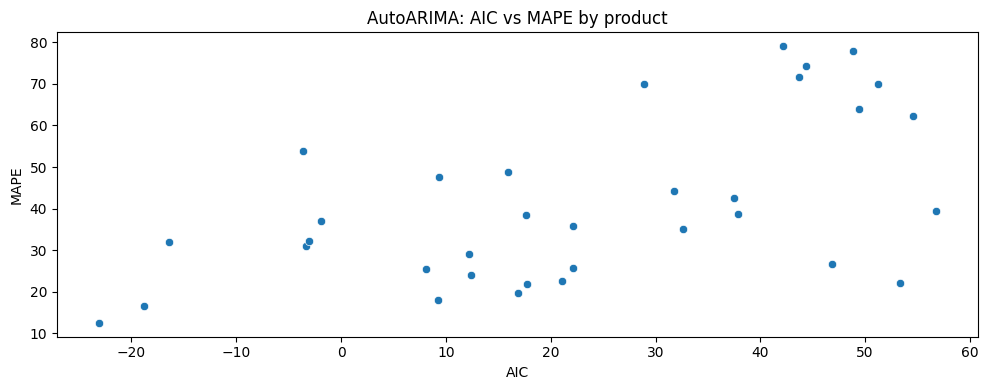

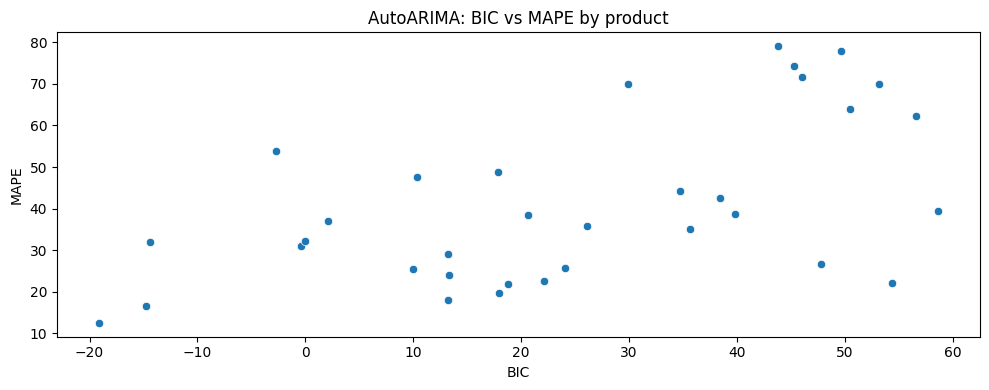

In [ ]:
if auto_errors:
    auto_errors_df = pd.DataFrame(auto_errors)

    plt.figure(figsize=(10, 4))
    sns.scatterplot(data=auto_errors_df, x="AIC", y="MAPE")
    plt.title("AutoARIMA: AIC vs MAPE by product")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.scatterplot(data=auto_errors_df, x="BIC", y="MAPE")
    plt.title("AutoARIMA: BIC vs MAPE by product")
    plt.tight_layout()
    plt.show()

**Insights – AutoARIMA Diagnostics**
- AutoARIMA selects orders via AIC/BIC, but the scatter shows higher criteria values clustering with elevated MAPE, meaning the automated search is overfitting short series.
- Several SKUs exceed 80–100% MAPE despite reasonable AIC/BIC, confirming that limited history (24 points) keeps the automated approach from learning multi-cycle seasonality.
- Recommendation: keep AutoARIMA as a benchmarking artifact, but promote the SARIMAX baseline for production until more history or exogenous drivers (per `documents/strategy/data_analytics_playbook.md`) become available.


In [ ]:
auto_mape_df.head(20)

,Product,MAPE,AIC,BIC
0,FS2500,38.532261,17.690245,20.677442
1,FS3410,69.852305,28.939422,29.935154
2,FS3600,42.592593,37.521986,38.466425
3,FS6400,35.809634,22.130231,26.113160
4,FX2421,70.061186,51.212192,53.203657
5,HD6500,44.354736,31.751306,34.738503
6,RS1221+,12.529260,-23.119512,-19.136583
7,RS1221RP+,16.657338,-18.776895,-14.793966
8,RS1619xs+,31.029080,-3.374963,-0.387766
9,RS2423+,24.051119,12.370337,13.314776
